<a href="https://colab.research.google.com/github/HalyshAnton/AdaIN/blob/main/AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import*
import numpy as np
import matplotlib.pyplot as plt

Layer = keras.layers.Layer
IMAGE_SIZE = (512, 512)

##Building model

In [ ]:
class VggPreprocess(Layer):

    def __init__(self, **kwargs):
        super(VggPreprocess, self).__init__(**kwargs)

    def call(self, x):
        import numpy as np
        x = tf.reverse(x, axis=[-1])
        x = x - tf.constant(np.array([103.939, 116.779, 123.68], dtype=np.float32))
        return x


class PostPreprocess(Layer):

    def __init__(self, **kwargs):
        super(PostPreprocess, self).__init__(**kwargs)

    def call(self, x):
        x = tf.clip_by_value(x, clip_value_min=0.0, clip_value_max=1.0)
        x = x * 255
        return x


class SpatialReflectionPadding(Layer):

    def __init__(self, **kwargs):
        super(SpatialReflectionPadding, self).__init__(**kwargs)

    def call(self, x):
        return tf.pad(x, tf.constant([[0,0], [1,1], [1,1], [0,0]]), mode="REFLECT")


class AdaIN(Layer):
    def __init__(self, alpha=1.0, **kwargs):
        self.alpha = alpha
        super(AdaIN, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        assert input_shape[0] == input_shape[1]
        return input_shape[0]

    def call(self, x):
        assert isinstance(x, list)
        # Todo : args
        content_features, style_features = x[0], x[1]
        style_mean, style_variance = tf.nn.moments(style_features, [1,2], keepdims=True)
        content_mean, content_variance = tf.nn.moments(content_features, [1,2], keepdims=True)
        epsilon = 1e-5
        normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                                content_variance, style_mean,
                                                                tf.sqrt(style_variance), epsilon)
        normalized_content_features = self.alpha * normalized_content_features + (1 - self.alpha) * content_features
        return normalized_content_features


In [ ]:
def vgg_encoder(path, input_shape=[None,None,3]):

    def _build_model(input_shape):
        x = Input(shape=input_shape, name="input")
        img_input = x

        # Block 1
        x = VggPreprocess()(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='block1_conv1')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='block1_conv2')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

        # Block 2
        x = SpatialReflectionPadding()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='block2_conv1')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='block2_conv2')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

        # Block 3
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv1')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv2')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv3')(x)
        x = SpatialReflectionPadding()(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv4')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

        # Block 4
        x = SpatialReflectionPadding()(x)
        x = Conv2D(512, (3, 3), activation='relu', padding='valid', name="output")(x)
        model = keras.models.Model(img_input, x, name='vgg19')
        return model
    model = _build_model(input_shape)
    model.load_weights(path)
    return model

In [ ]:
def vgg_decoder(path, input_shape=[None,None,512]):
    input = Input(shape=input_shape, name="input")
    x = input

    # Block 4
    x = SpatialReflectionPadding()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block4_conv1_decode')(x)
    x = UpSampling2D()(x)

    # Block 3
    x = SpatialReflectionPadding()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv1_decode')(x)
    x = SpatialReflectionPadding()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv2_decode')(x)
    x = SpatialReflectionPadding()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='valid', name='block3_conv3_decode')(x)
    x = SpatialReflectionPadding()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='block3_conv4_decode')(x)
    x = UpSampling2D()(x)

    # Block 2
    x = SpatialReflectionPadding()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='valid', name='block2_conv1_decode')(x)
    x = SpatialReflectionPadding()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='block2_conv2_decode')(x)
    x = UpSampling2D()(x)

    # Block 1
    x = SpatialReflectionPadding()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='valid', name='block1_conv1_decode')(x)
    x = SpatialReflectionPadding()(x)
    x = Conv2D(3, (3, 3), activation=None, padding='valid', name='block1_conv2_decode')(x)
    x = PostPreprocess(name="output")(x)

    model = keras.models.Model(input, x, name='decoder')
    model.load_weights(path)
    return model

In [ ]:
encoder = vgg_encoder('/content/vgg_encoder.h5')
decoder = vgg_decoder('/content/vgg_decoder.h5')

##Load images

In [ ]:
def decode_and_resize(image_name, image_url):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image_path = keras.utils.get_file(image_name+".jpg", image_url)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image[None, :]
    image = tf.cast(image, dtype="float32")
    return image

In [ ]:
images = {'Labrador': 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg',
          'kandinsky7': 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
          "Van Gogh": "https://ukrburshtyn.com/upload/custom/images/Van%20Gogh-Starry_Night.jpg",
          "The Great Wave": "http://info.sibnet.ru/ni/276/276160b.jpg",
          "Pikasso_gernika": "https://muzei-mira.com/templates/museum/images/paint/gernika-pikasso-.jpg",
          "People": "https://g2.dcdn.lt/images/pix/shutterstock-1698317260-84489777.jpg",
          "Space": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/HH_901_and_HH_902_in_the_Carina_nebula_%28captured_by_the_Hubble_Space_Telescope%29.jpg/800px-HH_901_and_HH_902_in_the_Carina_nebula_%28captured_by_the_Hubble_Space_Telescope%29.jpg",
          "Tuebingen_Neckarfront": "https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg?20050413074615",
          "Zebra_stripes": "https://st4.depositphotos.com/15317184/20895/v/950/depositphotos_208957672-stock-illustration-zebra-stripes-pattern-zebra-print.jpg?forcejpeg=true",
          "Pencil_woman": "https://i.pinimg.com/736x/f2/d1/7f/f2d17f42d56e802f8ae211c829e87c76.jpg"}

In [ ]:
images = {name: decode_and_resize(name, images[name]) for name in images}

103775/103775 [==============================] - 0s 0us/step


##Stylization

### degree of stylization

In [ ]:
def stylize_alpha(content, style, alpha=1):
  content_f = encoder.predict(content, verbose=0)
  style_f = encoder.predict(style, verbose=0)

  t = AdaIN(alpha)([content_f, style_f])

  image = decoder.predict(t, verbose=0)
  image = image.astype(np.uint8)
  return image


In [ ]:
content = images["People"]
style = images["Pencil_woman"]

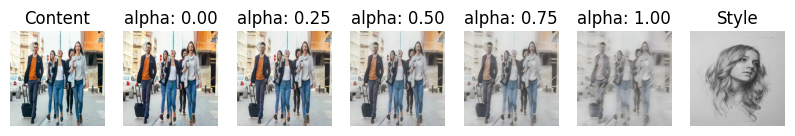

In [ ]:
alphas = np.linspace(0, 1, 5, endpoint=True)
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(10, 10))
[ax.axis("off") for ax in np.ravel(axes)]

axes[0].imshow(content[0]/255)
axes[0].set_title("Content")

axes[-1].imshow(style[0]/255)
axes[-1].set_title("Style")

for ax, alpha in zip(axes[1:-1], alphas):
  image = stylize_alpha(content, style, alpha)[0]

  ax.imshow(image)
  ax.set_title(f"alpha: {alpha:.2f}")


###style interpolation

In [ ]:
content = images["Tuebingen_Neckarfront"]
styles = [images["Space"],
          images['Pikasso_gernika'],
          images["Zebra_stripes"],
          #images['kandinsky7'],
          images["Van Gogh"]]

In [ ]:
def stylize_weighted(content, styles, weights):
  content_f = encoder.predict(content, verbose=0)
  t = 0

  for style, weight in zip(styles, weights):
    style_f = encoder.predict(style, verbose=0)
    t += weight*AdaIN(alpha=1)([content_f, style_f])

  image = decoder.predict(t, verbose=0)
  image = image.astype(np.uint8)
  return image

In [ ]:
def calculate_weights(i, j, nrows, ncols):
  point = np.array([i, j])
  weights = []

  for vertex_i in [0, nrows]:
    for vertex_j in [0, ncols]:
      vertex = np.array([vertex_i, vertex_j])
      weight = 1 / np.sum(np.abs(vertex-point))

      weights.append(weight**2)

  weights = np.array(weights)
  return weights/np.sum(weights)

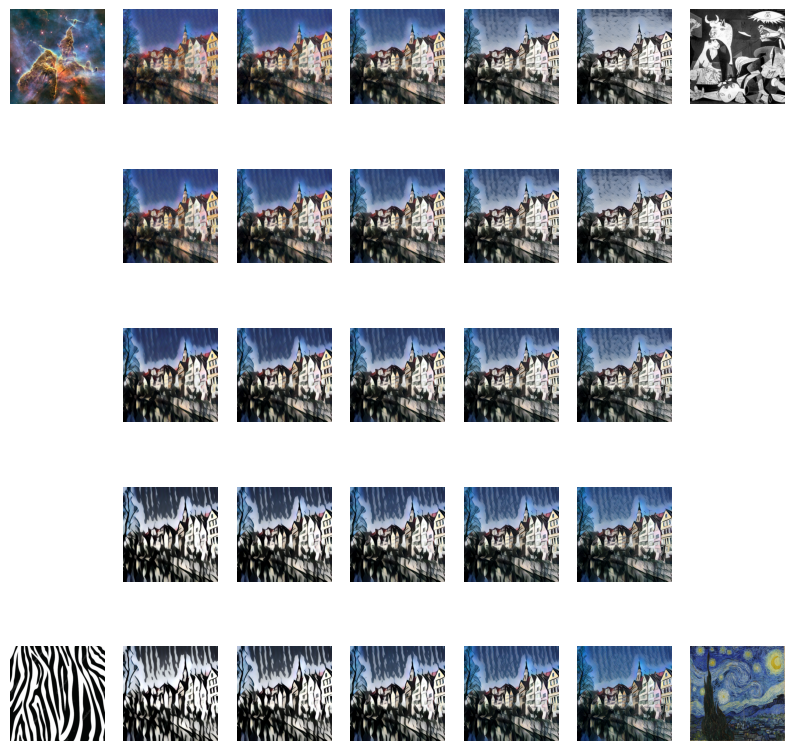

In [ ]:
nrows = 5
ncols = 7
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
[ax.axis("off") for ax in np.ravel(axes)]

axes[0, 0].imshow(styles[0][0]/255)
axes[0, -1].imshow(styles[1][0]/255)
axes[-1, 0].imshow(styles[2][0]/255)
axes[-1, -1].imshow(styles[3][0]/255)

for i in range(0, nrows):
  for j in range(1, ncols-1):
    weights = calculate_weights(i, j, nrows, ncols)
    image = stylize_weighted(content, styles, weights)
    axes[i, j].imshow(image[0])

###color control

In [ ]:
def get_pixel_matrix(image):
  if len(image.shape) > 3:
    image = image[0]

  pixels = np.transpose(image, [2, 0, 1])
  pixels = pixels.reshape((3, -1))

  return pixels/255

def get_pixel_moments(image, eps=1e-5):
  pixels = get_pixel_matrix(image)
  mean = np.mean(pixels, axis=1, keepdims=True)
  pixels_meaned = pixels - mean
  K = pixels_meaned @ pixels_meaned.T + eps*np.eye(3)

  return pixels, mean, K

def get_square_root(M):
  val, vec = np.linalg.eig(M)

  return vec @ np.diag(np.sqrt(val)) @ np.linalg.inv(vec)

def color_control(content, style, mode="chol"):
  pixels_c, mean_c, Kc = get_pixel_moments(content)
  pixels_s, mean_s, Ks = get_pixel_moments(style)

  # compute matrix A for transformation
  if mode == "chol":
    Lc = np.linalg.cholesky(Kc)
    Ls = np.linalg.cholesky(Ks)
    A = Lc @ np.linalg.inv(Ls)

  elif mode == "pca":
    Kc_1_2 = get_square_root(Kc)
    Ks_1_2 = get_square_root(Ks)
    A = Kc_1_2 @ np.linalg.inv(Ks_1_2)

  elif mode == "sym":
    Ks_1_2 = get_square_root(Ks)
    Q = Ks_1_2 @ Kc @ Ks_1_2
    Q_1_2 = get_square_root(Q)
    A = np.linalg.inv(Ks_1_2) @ Q_1_2 @ np.linalg.inv(Ks_1_2)

  new_pixels_s = A @ (pixels_s - mean_s) + mean_c
  new_pixels_s = np.transpose(new_pixels_s, [1, 0])
  new_style = new_pixels_s.reshape(style.shape)
  new_style *= 255
  new_style = new_style.astype(np.int32)
  return new_style

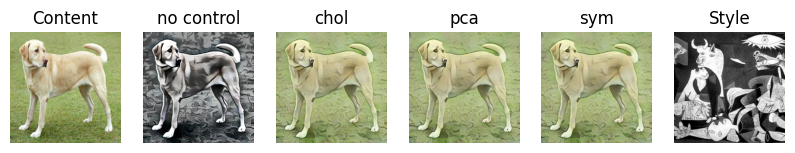

In [ ]:
content = images["Labrador"]
style = images["Pikasso_gernika"]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 10))
[ax.axis("off") for ax in np.ravel(axes)]

axes[0].imshow(content[0]/255)
axes[0].set_title("Content")

axes[-1].imshow(style[0]/255)
axes[-1].set_title("Style")

modes = ["no control", "chol", "pca", "sym"]

for ax, mode in zip(axes[1:-1], modes):
  if mode == "no control":
    new_style = style
  else:
    new_style = color_control(content, style)

  image = stylize_alpha(content, new_style)[0]
  ax.imshow(image)
  ax.set_title(f"{mode}")